### Практика

### Case 1

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [151]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import plotly
import plotly.graph_objs as go
import plotly.express as px
import plotly.offline as py
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

import matplotlib.pyplot as plt

%matplotlib inline

Загружаем, удаляем неинформативные столбцы, кодируем категории

In [152]:
df = pd.read_csv("churn_data.csv")
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)
df = pd.get_dummies(df, ['Geography', 'Gender'])

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0


Немножко EDA. За кадром я уже построил графики и подобрал пороги

In [153]:
df['CreditScore_high'] = 0; df.loc[df['CreditScore'] == 850, 'CreditScore_high'] = 1
df['CreditScore_low'] = 0; df.loc[df['CreditScore'] < 395, 'CreditScore_low'] = 1
df['Age_high'] = 0; df.loc[df['Age'] > 62, 'Age_high'] = 1
df['Null_Balance'] = 0; df.loc[df['Balance'] == 0, 'Null_Balance'] = 1
df['Balance_high'] = 0; df.loc[df['Balance'] > 198.3388, 'Balance_high'] = 1
df['Balance_low'] = 0; df.loc[(df['Balance'] < 41.29903) & (df['Balance'] != 0), 'Balance_low'] = 1
df['NumOfProducts_outliar'] = 0; df.loc[df['NumOfProducts'] == 4, 'NumOfProducts_outliar'] = 1

In [154]:
#df_temp = df['CreditScore']
#df_temp =  df.loc[(df['CreditScore_low'] == 0) & (df['CreditScore_high'] == 0), 'CreditScore']

#fig = px.scatter(x=df_temp, marginal_x="histogram")
#fig.show()

#fig = px.box(x=df_temp)
#fig.show()

Столбец с ответами отдельно, чтобы не мешал

In [155]:
df_y = df['Exited']
df.drop(['Exited'], axis='columns', inplace=True)

Больше фичей

In [156]:
poly = PolynomialFeatures(degree=5)
df_P_Features = pd.DataFrame(poly.fit_transform(df[['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Tenure']]))
poly.get_feature_names(['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Tenure'])
df_P_Features.columns=poly.get_feature_names(['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Tenure'])
df_P_Features.drop(['1', 'CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Tenure'], axis='columns', inplace=True)
df = pd.concat([df, df_P_Features], sort=False, axis=1)

Скалируем

In [ ]:
pt = PowerTransformer()
#pt = StandardScaler()
df_scaled = pd.DataFrame(pt.fit_transform(df))
df_scaled.columns = df.columns

In [158]:
#df_temp = df_scaled['EstimatedSalary']

#fig = px.scatter(x=df_temp, marginal_x="histogram")
#fig.show()

#fig = px.box(x=df_temp)
#fig.show()

Запускаем TSNE. За кадром я уже поэксперементировал с параметрами

In [160]:
df_scaled_TSNE = pd.DataFrame(TSNE(n_components=2, init='random', perplexity=50, n_iter=5000).fit_transform(df_scaled), columns=['x', 'y'])

Напустим DBSCAN на результат

In [161]:
clustering = DBSCAN(eps=7, min_samples=5).fit(df_scaled_TSNE)

In [149]:
fig = px.scatter(x=df_scaled_TSNE['x'], y=df_scaled_TSNE['y'], color=clustering.labels_)
fig.show()

In [164]:
import umap
reducer = umap.UMAP()
df_scaled_UMAP = pd.DataFrame(reducer.fit_transform(df_scaled), columns=['x', 'y'])

In [172]:
fig = px.scatter(x=df_scaled_UMAP['x'], y=df_scaled_UMAP['y'], color=clustering.labels_)
fig.show()

UMAP разделил на те же 6 классов и это хорошо.

Теперь немножко классической кластеризации

In [208]:
for eps in range(1, 201):
    for min_samples in range(2, 6):
        DBSCAN_test = DBSCAN(eps=eps/10, min_samples=min_samples).fit(df_scaled)
        if len(set(DBSCAN_test.labels_)) > 1:
            print("eps: ", eps, " min_samples: ", min_samples, " silhouette_score: ", 
                  metrics.silhouette_score(df_scaled, DBSCAN_test.labels_, metric='euclidean'))
        else:
            print("eps: ", eps, " min_samples: ", min_samples, " silhouette_score: nothing")

eps:  1  min_samples:  2  silhouette_score:  -0.040456779398480254
eps:  1  min_samples:  3  silhouette_score: nothing
eps:  1  min_samples:  4  silhouette_score: nothing
eps:  1  min_samples:  5  silhouette_score: nothing
eps:  2  min_samples:  2  silhouette_score:  -0.040456779398480254
eps:  2  min_samples:  3  silhouette_score: nothing
eps:  2  min_samples:  4  silhouette_score: nothing
eps:  2  min_samples:  5  silhouette_score: nothing
eps:  3  min_samples:  2  silhouette_score:  -0.040456779398480254
eps:  3  min_samples:  3  silhouette_score: nothing
eps:  3  min_samples:  4  silhouette_score: nothing
eps:  3  min_samples:  5  silhouette_score: nothing
eps:  4  min_samples:  2  silhouette_score:  -0.4517394480105114
eps:  4  min_samples:  3  silhouette_score: nothing
eps:  4  min_samples:  4  silhouette_score: nothing
eps:  4  min_samples:  5  silhouette_score: nothing
eps:  5  min_samples:  2  silhouette_score:  -0.4659659672914346
eps:  5  min_samples:  3  silhouette_score: n

KeyboardInterrupt: 

In [206]:





from sklearn.model_selection import GridSearchCV

param_grid = [
  {'eps': [i/10 for i in range(1, 201)], 'min_samples': [2, 3, 4, 5, 6]},
 ]
estimator=DBSCAN()

search = GridSearchCV(estimator,
                      param_grid,
                      scoring=metrics.silhouette_score(df_scaled, estimator.fit().labels, metric='euclidean'),
                      cv=5,
                      n_jobs=-1,
                      verbose=4).fit(df_scaled)


TypeError: fit() missing 1 required positional argument: 'X'

In [180]:
from sklearn import metrics
print(metrics.silhouette_score(df_scaled_TSNE, clustering.labels_, metric='euclidean'))
print(metrics.silhouette_score(df_scaled_UMAP, clustering.labels_, metric='euclidean'))

0.56654817
0.7733023


In [179]:
print(metrics.calinski_harabasz_score(df_scaled_TSNE, clustering.labels_))
print(metrics.calinski_harabasz_score(df_scaled_UMAP, clustering.labels_))

13580.25801605676
45182.90268227816


In [178]:
print(metrics.davies_bouldin_score(df_scaled_TSNE, clustering.labels_))
print(metrics.davies_bouldin_score(df_scaled_UMAP, clustering.labels_))

0.43985184559536905
0.26259643569529173


Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [12]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Обучим модель

In [13]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

Отрисуем матрицу ошибок

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


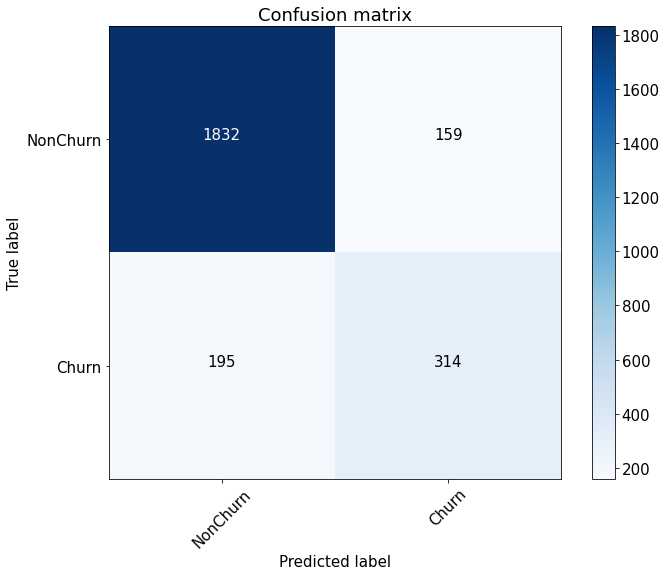

In [18]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

### Пример с перебором параметров с помощью GridSearch

Сетка с параметрами

In [3]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

Запускаем перебор

In [20]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 3}

Обучаем модель уже сновыми параметрами

In [21]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.389431, F-Score=0.653, Precision=0.661, Recall=0.646
Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


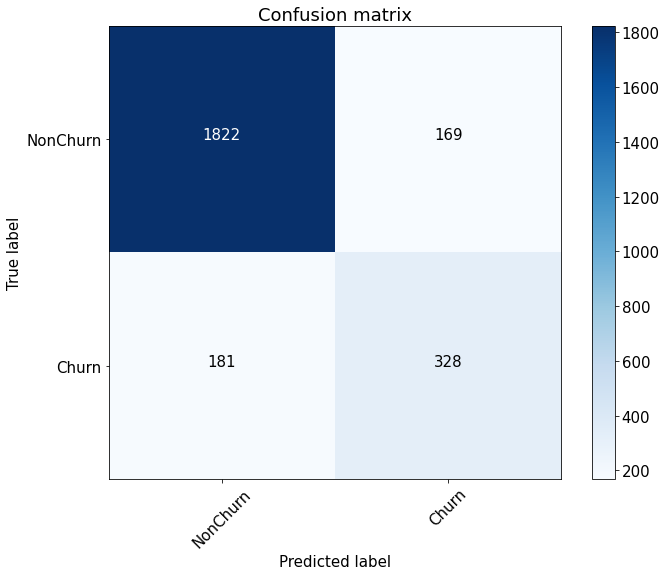

In [22]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Метрики немного стали выше

### Кейс 2. Отток пользователей в онлайн-игре

https://mlbootcamp.ru/ru/round/10/sandbox/

В этой задаче необходимо научиться предсказывать, остается ли участник в он-лайн игре или уходит из нее. Уходом считается отсутствие его в игре в течение недели.

 

Всего используется 12 признаков, вычисленных за 2 предыдущие недели:

- maxPlayerLevel - максимальный уровень игры, который прошел игрок
- numberOfAttemptedLevels - количество уровней, которые попытался пройти игрок
- attemptsOnTheHighestLevel - число попыток, сделанных на самом высоком уровне
- totalNumOfAttempts - общее число попыток
- averageNumOfTurnsPerCompletedLevel - среднее количество ходов, выполненных на успешно пройденных уровнях
- doReturnOnLowerLevels - делал ли игрок возвраты к игре на уже пройденных уровнях
- numberOfBoostersUsed - количество использованных бустеров
- fractionOfUsefullBoosters - количество бустеров, использованных во время успешных попыток (игрок прошел уровнь)
- totalScore - общее количество набранных очков
- totalBonusScore - общее количество набранных бонусных очков
- totalStarsCount - общее количество набранных звезд
- numberOfDaysActuallyPlayed - количество дней, когда пользователь играл в игру

Все предоставленные для задачи данные разбиты на две части: обучающую (x_train.csv и y_train.csv) и тестовую (x_test.csv). Каждая строка файлов x_train.csv и x_test.csv соответствует одному пользователю. Данные в строке разделены точкой с запятой. Первая строка содержит имена признаков. Файл y_train.csv содержит значения 1 или 0 в зависимости от того, остался пользователь в игре или вышел из нее соответственно.

Как обучающая (x_train.csv и y_train.csv), так и тестовая (x_test.csv) выборки содержат информацию о 25289 пользователях.

Решение победителя https://habr.com/ru/post/324916/ (немного адаптированное)

In [23]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import random

random.seed(666)
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/artemzraev/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
def loss_func(y_true, y_pred):
    return log_loss(y_true, y_pred)


all_train = pd.read_csv('x_train.csv', sep=';')
all_target = pd.read_csv('y_train.csv', sep=';', names=['TARGET'])
all_train['TARGET'] = all_target['TARGET']

In [25]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(all_train, all_train['TARGET'], random_state=0)

In [26]:
cols_to_drop = ['ID', 'TARGET']
cols = list(set(all_train.columns) - set(cols_to_drop))
base_cols = cols

In [27]:
# определи группы одинаковых строк
X_train['row_id'] = X_train[base_cols].apply(lambda row: '_'.join([str(i) for i in row]), axis=1)
X_test['row_id'] = X_test[base_cols].apply(lambda row: '_'.join([str(i) for i in row]), axis=1)

gb = X_train.groupby(['row_id'], as_index=False).size()
gb.name = 'size'
gb = gb.reset_index()
sizdata = gb[gb['size'] > 50].sort_values('size', ascending=False)

similar_data = X_train[X_train['row_id'].isin(sizdata['row_id'].values)]

/Users/artemzraev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/artemzraev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# генерируем признаки
def transform_data(data):
    for i1, col1 in enumerate(base_cols):
        data[col1 + '_log'] = np.log(data[col1] + 1.1)

        for i2, col2 in enumerate(base_cols):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
            data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
            data['%s_%s_3' % (col1, col2)] = data[col1] / (data[col2] + 0.1)
            data['%s_%s_4' % (col1, col2)] = data[col1] * data[col2]

            data['%s_%s_11' % (col1, col2)] = data[col1] - np.log(data[col2] + 1)
            data['%s_%s_22' % (col1, col2)] = data[col1] + np.log(data[col2] + 1)
            data['%s_%s_33' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 0.1)
            data['%s_%s_44' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)

    return data


X_train_tr = transform_data(X_train)
X_test_tr = transform_data(X_test)

/Users/artemzraev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/artemzraev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/artemzraev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [29]:
cols = [col for col in X_train_tr.drop(['TARGET', 'row_id'], 1).columns]

In [38]:
len(cols)

1176

In [31]:
# выборки для разных моделей
X_train_gb = X_train[cols].values

scaler_reg = MinMaxScaler((-1, 1))
scaler_reg.fit(np.vstack((X_train_tr[cols], X_test_tr[cols])))
X_train_reg = scaler_reg.transform(X_train_tr[cols])
X_test_reg = scaler_reg.transform(X_test_tr[cols])

In [32]:
# ------------------------------------------------------------------
params = {
    'silent': 1,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.01,
    'subsample': 0.4,
    'min_child_weight': 7,
    'n': 580,
    'verbose': 1
}

dtrain = xgb.DMatrix(X_train_tr[cols], label=y_train, missing=np.NaN)


bst1 = xgb.XGBClassifier(boosting_type='gbdt', **params)
bst1.fit(X_train_tr[cols], y_train)
# ------------------------------------------------------------------
params_est = {
    'n_estimators': 300,
    'loss': 'exponential',
    'learning_rate': 0.08,
    'subsample': 0.6910000000000001,
    'min_samples_leaf': 340,
    'max_features': 53,
    'random_state': 1,
    'verbose': 1
}
bst2 = GradientBoostingClassifier(**params_est)
bst2.fit(X_train_tr[cols], y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8752           0.0306           28.45s
         2           0.8490           0.0270           26.50s
         3           0.8228           0.0232           25.34s
         4           0.8011           0.0208           25.05s
         5           0.7875           0.0187           24.63s
         6           0.7726           0.0169           24.11s
         7           0.7532           0.0149           23.86s
         8           0.7403           0.0135           24.74s
         9           0.7261           0.0110           25.16s
        10           0.7174           0.0102           24.89s
        20           0.6573           0.0026           22.68s
        30           0.6411           0.0005           22.87s
        40           0.6414           0.0003           22.11s
        50           0.6328          -0.0001           21.76s
        60           0.6312          -0.0002           20.55s
       

GradientBoostingClassifier(learning_rate=0.08, loss='exponential',
                           max_features=53, min_samples_leaf=340,
                           n_estimators=300, random_state=1,
                           subsample=0.6910000000000001, verbose=1)

In [33]:
#обычная логистическая регрессия
bst3 = LogisticRegression()
bst3.fit(X_train_reg, y_train)

/Users/artemzraev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

Посчитаем скоры

In [34]:
t1 = bst1.predict_proba(X_test_tr[cols])[:, 1]
t2 = bst2.predict_proba(X_test_tr[cols].values)[:,1]
t3 = bst3.predict_proba(X_test_reg)[:,1]

Объединим все

In [39]:
results = pd.DataFrame({'y_true': y_test,
              'XGB': t1,
              'GBM': t2,
              'LR': t3})
results['AVG_xgb_gbm_lr'] = results[['XGB', 'GBM', 'LR']].mean(axis=1)
results['AVG_xgb_lr'] = results[['XGB', 'LR']].mean(axis=1)
results

,y_true,XGB,GBM,LR,AVG_xgb_gbm_lr,AVG_xgb_lr
8424,1,0.617778,0.658450,0.663960,0.646729,0.640869
6504,0,0.201586,0.021024,0.026161,0.082923,0.113873
11281,0,0.358372,0.274722,0.193555,0.275550,0.275964
15938,1,0.744776,0.934983,0.943830,0.874530,0.844303
9213,0,0.334519,0.226526,0.241877,0.267641,0.288198
...,...,...,...,...,...,...
7817,0,0.317555,0.242057,0.235459,0.265024,0.276507
23443,0,0.614049,0.583713,0.656765,0.618176,0.635407
9533,0,0.219870,0.027528,0.076761,0.108053,0.148316
24432,1,0.596148,0.607901,0.649319,0.617789,0.622734


Посчитаем метрики

In [40]:
def get_metrics(probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix],
                                                                            roc_auc_score(y_test, probs)))
    return thresholds[ix]

In [41]:
xgb_th = get_metrics(results['XGB'])
gbm_th = get_metrics(results['GBM'])
lr_th = get_metrics(results['LR'])
blending_th = get_metrics(results['AVG_xgb_gbm_lr'])
blending2_th = get_metrics(results['AVG_xgb_lr'])

Best Threshold=0.429864, F-Score=0.716, Precision=0.671, Recall=0.768, Roc-AUC=0.881
Best Threshold=0.379965, F-Score=0.714, Precision=0.668, Recall=0.768, Roc-AUC=0.880
Best Threshold=0.386944, F-Score=0.714, Precision=0.668, Recall=0.767, Roc-AUC=0.880
Best Threshold=0.384646, F-Score=0.715, Precision=0.660, Recall=0.780, Roc-AUC=0.882
Best Threshold=0.406123, F-Score=0.714, Precision=0.666, Recall=0.769, Roc-AUC=0.881


Ничего особенного блендинг нам не дает, но вполне возможно, что при большем количестве моделей результат может быть иным. 

### Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html
7. https://habr.com/ru/post/292312/
8. https://habr.com/ru/post/436236/
9. https://lifetimes.readthedocs.io/en/master/